importing Jupyter notebook from Vogel.ipynb
100 year return period precipitation:8919.79 inch


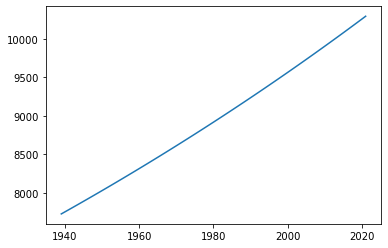

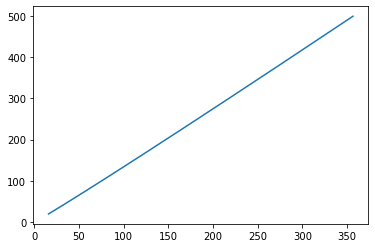

   100 year storm  200 year storm  500 year storm  1000 year storm
0      100.000000      200.000000      500.000000      1000.000000
1       75.436580      147.242416      357.263857       699.552480
2       57.502741      109.551957      258.019871       494.677192
3       44.288476       82.369608      188.339704       353.579363
         station_04208000.csv  station_04196800.csv  station_04195500.csv  \
delta_t                                                                     
0                    1.000000              1.000000              1.000000   
10                   1.049586              1.067905              1.044326   
20                   1.101632              1.140421              1.090616   
30                   1.156258              1.217862              1.138959   

         station_04189000.csv  station_03117000.csv  
delta_t                                              
0                    1.000000              1.000000  
10                   1.048049           

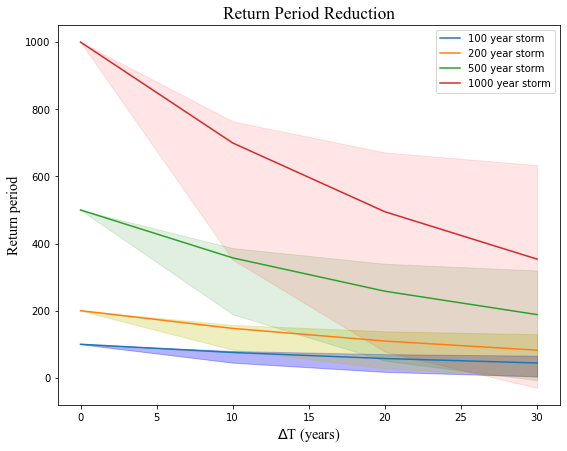

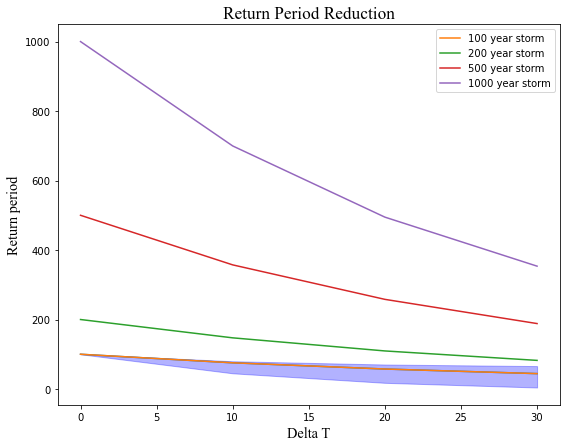

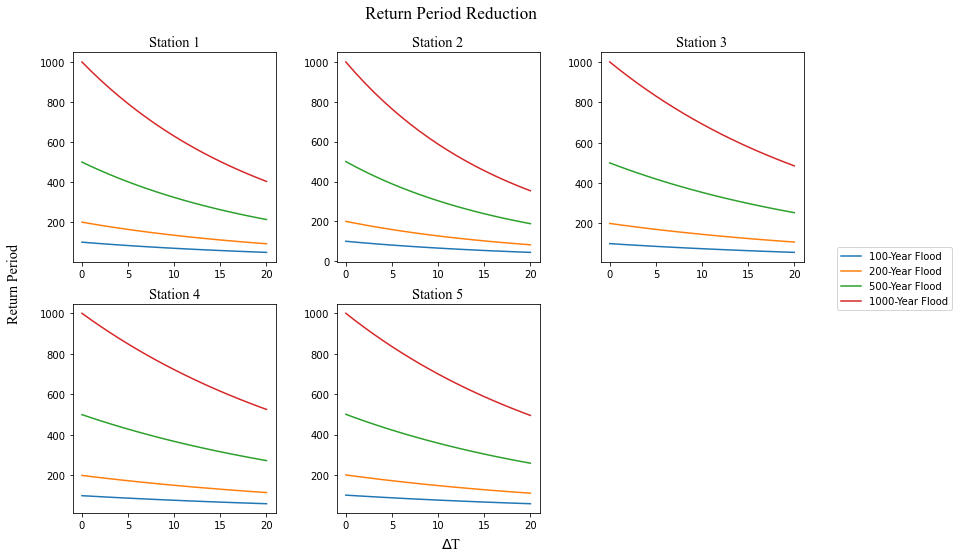

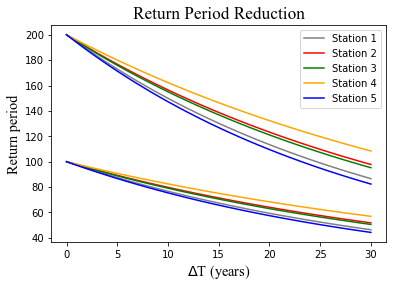

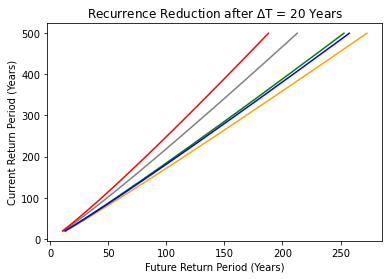

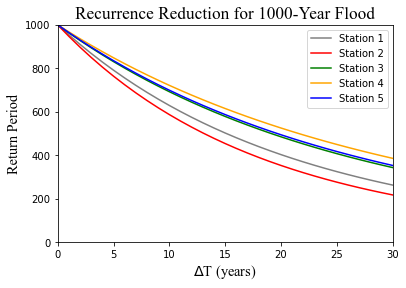

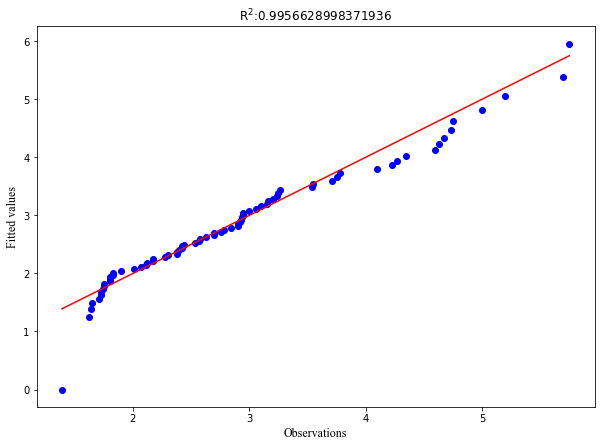

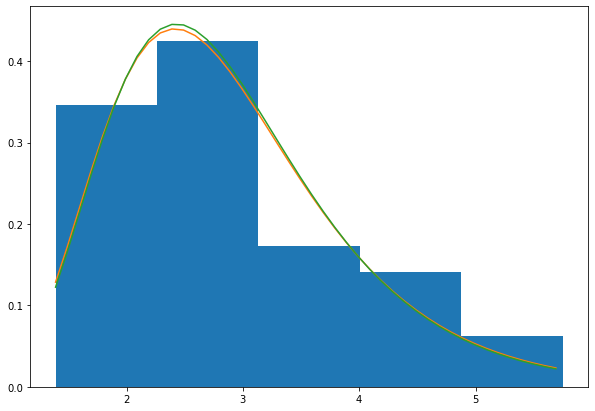

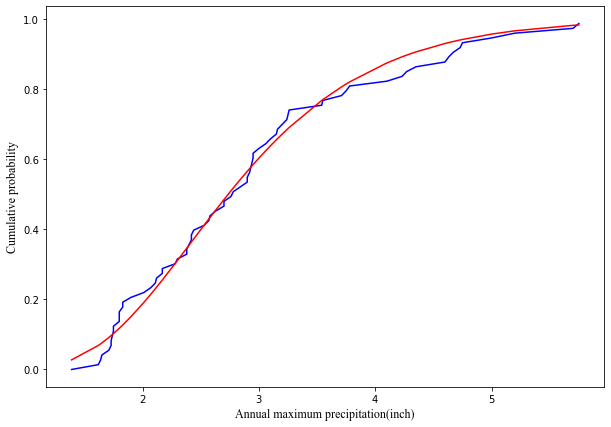

importing Jupyter notebook from Fall_trend_test.ipynb


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats as ss
import scipy.signal
from astropy.stats import bootstrap as bootstrap
from statsmodels.tsa.ar_model import AutoReg
import math
import common_func as cf
import import_ipynb
from Vogel import find_trend as ft
import check_ln2

import Fall_trend_test as Fall

In [2]:

#MannKendall Test

# function for determining tie groups and corresponding number of ties.
def count_ties(x):
    ties = []
    y = x
    while len(x) > 0: 
        ties.append(np.where(x == x[0])[0].size)
        x = np.delete(x, np.where(x == x[0]))
    ties=np.array(ties)
    return ties

#function for calculating variance in mann kendall test
def var(x):
    n = len(x)
    var = n * (n - 1) * (2 * n + 5)
    e = count_ties(x)
    extent_sum = np.sum(e * (e - 1) * (2 * e + 5))
    return  (var - extent_sum)/18

# function for testing pvalue and critical value of mann kendall test
def mktest(z):
    alpha = 0.05    # alpha = 0.1 
    CritVal = np.abs(ss.norm.ppf(alpha / 2))
    pvalue = ss.norm.sf(np.abs(z)) * 2 
    print('pvalue:',pvalue)
# Reject H0 if |Z-Score| > CritVal and, equivalently, if p-value < alpha/2
    reject1 = CritVal < np.abs(z)
    reject2 = pvalue < alpha
    if reject1:
        return 'Yes'
    return 'No'
# Mann Kendall Test
def main_mk(maxQ):
    T = 0
    data = np.log(maxQ)
    for j in range(len(data)-1):
        t = data[j] - (data[j+1:])
        T += (np.where(t < 0))[0].size - (np.where(t > 0))[0].size
    variance = var(data)
    if T > 0:
        z = (T - 1)/(np.sqrt(variance))
    else:
        z = (T + 1)/(np.sqrt(variance))
    print('Z_value:',z)
    trend = mktest(z)
    print('Is there a monotonic trend?',trend,'\n')

In [3]:
def acf_pacf(maxQ):
    sm.graphics.tsa.plot_acf(np.log(maxQ))
    plt.show()
    sm.graphics.tsa.plot_pacf(np.log(maxQ))
    plt.show()

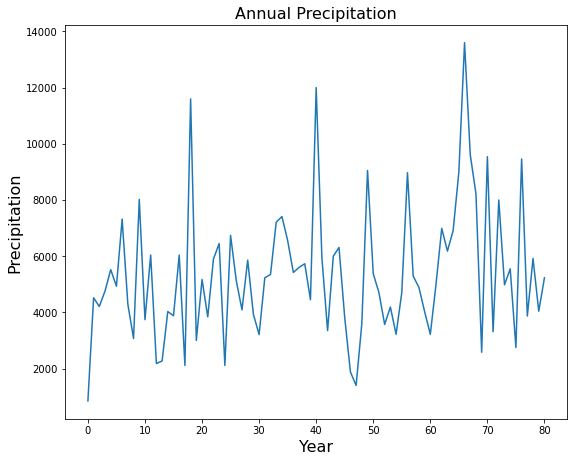

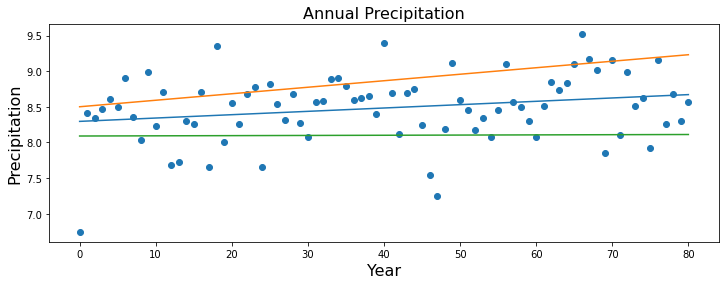

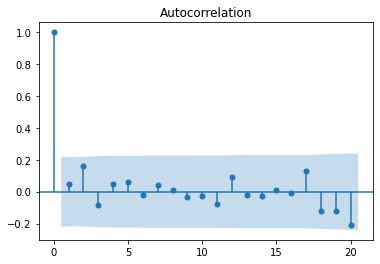

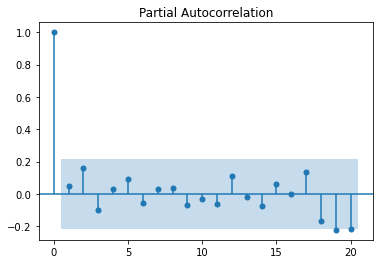

Z_value: 1.7415664972444922
pvalue: 0.08158432799665191
Is there a monotonic trend? No 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     4.448
Date:                Tue, 08 Mar 2022   Prob (F-statistic):             0.0381
Time:                        10:56:44   Log-Likelihood:                -52.459
No. Observations:                  81   AIC:                             108.9
Df Residuals:                      79   BIC:                             113.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------

In [7]:
# Streamflow data: Stations 1-5: 
# Stations = ['station_04208000.csv','station_04196800.csv','station_04195500.csv','station_04189000.csv','station_03117000.csv']

Data = pd.read_csv('station_04189000.csv')
maxQ, yearMaxQ = cf.annual_max(Data)
###FALL
# maxQ, yearMaxQ = Fall.Fall_max(Data)

#Using Index years
yearMaxQ = np.arange(0,len(yearMaxQ),1) 

#OLS regression: 
lr = ft(np.log(maxQ), yearMaxQ)
#Trend Line: 
beta = lr.params[1]
interc = lr.params[0]
y = beta*yearMaxQ+interc
# Confidence Interval:
CI = lr.conf_int(alpha=0.05)
#higher CI:
beta_H = CI[1][1]
interc_H = CI[0][1]
yH = beta_H*yearMaxQ + interc_H
#Lower CI: 
beta_L = CI[1][0]
interc_L = CI[0][0]
yL = beta_L*yearMaxQ + interc_L


# Annual Max Plot: 
fig = plt.figure()
plt.plot(yearMaxQ, maxQ)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Precipitation', fontsize=16)
plt.title('Annual Streamflow', fontsize=16)
fig.set_size_inches([9, 7.25])
fig.savefig('Annual Precipitation', dpi=300)
plt.show()

#Annual Maxima with trend line plot: 
fig = plt.figure()
plt.scatter(yearMaxQ, np.log(maxQ))
plt.plot(yearMaxQ,y)
plt.plot(yearMaxQ,yH)
plt.plot(yearMaxQ,yL)
plt.xlabel('Year', fontsize=16)
# plt.xticks([0, 1, 2], ["a", "b", "c"])
plt.ylabel('Precipitation', fontsize=16)
plt.title('Annual Streamflow Trend for Station 1', fontsize=16)
fig.set_size_inches([12, 4])
fig.savefig('Annual Precipitation_CI', dpi=300)
plt.show()


#TESTS
# m = check_ln2.qq_plot(maxQ)
acf_pacf(maxQ)
main_mk(maxQ)
lr = ft(np.log(maxQ), yearMaxQ)
print(lr.summary())


In [5]:
#For all stations: 
Stations = ['station_04208000.csv','station_04196800.csv','station_04195500.csv','station_04189000.csv','station_03117000.csv']

# Mean flow and sigma
for s in Stations:
    data = pd.read_csv(s)
    maxQ, years = cf.annual_max(data)
    ybar,std, skew = cf.findmoments(maxQ)
    print(s + ' Mean: ' + str(ybar) + ' Sigma: ' + str(std))

station_04208000.csv Mean: 8018.888888888889 Sigma: 2658.653794686326
station_04196800.csv Mean: 3740.877192982456 Sigma: 1381.5290192673096
station_04195500.csv Mean: 6645.243902439024 Sigma: 2391.939254363977
station_04189000.csv Mean: 5358.395061728395 Sigma: 2401.624687992549
station_03117000.csv Mean: 4416.626506024097 Sigma: 1463.6466962638167


In [6]:
print(CI)

[[8.09039248e+00 8.50080135e+00]
 [2.64036290e-04 9.12201086e-03]]
